In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import gc
import sys
from statsmodels.formula.api import ols
from IPython.display import clear_output
from numba import njit, jit

In [21]:
df = pd.read_csv('SALES_2018_2019.csv', sep=',', nrows = 20000000)
df = df[df.stock > 0]
df.rename(columns={'stock': 'Demand', 'store_id': 'Store_ID', 'Code_AP' : 'SKU_ID', 'curr_date': 'Date', 'sales_regular': 'Sales','price_regular':'Regular_Price'}, inplace=True)
df.drop(columns = ['sales_promo','price_promo','flag_promo'])

,SKU_ID,Store_ID,Date,Demand,Sales,Regular_Price
0,114,1078,2018-07-01,2.0,2.0,30.0
1,114,1078,2018-08-05,2.0,0.0,30.0
2,114,1078,2018-08-06,2.0,0.0,30.0
3,114,1078,2018-08-07,2.0,0.0,30.0
4,114,1078,2018-08-08,2.0,0.0,30.0
...,...,...,...,...,...,...
19999995,9790,1127,2018-07-02,5.0,1.0,257.0
19999996,9790,1127,2018-07-03,4.0,2.0,257.0
19999997,9790,1127,2018-07-04,2.0,0.0,257.0
19999998,9790,1127,2018-07-05,2.0,0.0,257.0


In [24]:
df.Date = pd.to_datetime(df.Date)

In [28]:
df.Date[df.Date.dt.year == 2018] 

0          2018-07-01
1          2018-08-05
2          2018-08-06
3          2018-08-07
4          2018-08-08
              ...    
19999995   2018-07-02
19999996   2018-07-03
19999997   2018-07-04
19999998   2018-07-05
19999999   2018-07-06
Name: Date, Length: 9591187, dtype: datetime64[ns]

In [23]:
df = pd.read_csv('DATA_WITH_SALES.csv', sep=';')
df = df[df.Stock > 0]
df.rename(columns={'Stock': 'Demand'}, inplace=True)

df.head(n=5)

,Store_ID,SKU_ID,Date,Sales,Demand,Regular_Price
0,1100,114,01JAN2019,0.0,1.0,51.0
1,1078,114,01JAN2019,0.0,2.0,51.0
2,1191,114,01JAN2019,0.0,2.0,53.0
3,2230,114,01JAN2019,0.0,1.0,40.0
4,1120,114,01JAN2019,0.0,1.0,53.0


In [29]:
df1 = df[df.Date.dt.year == 2019] 
df = df[df.Date.dt.year == 2018] 

In [30]:
popular_pairs = df.groupby(['SKU_ID', 'Store_ID']).size().reset_index(name='counts').sort_values(by='counts', ascending=False).reset_index(drop=True)

In [31]:
popular_pairs.head(n=10)

,SKU_ID,Store_ID,counts
0,2681,1179,364
1,1063,1199,364
2,678,1178,364
3,7340,2834,364
4,678,1181,364
5,7450,2834,364
6,678,1200,364
7,4405,1172,364
8,1064,1181,364
9,1064,1175,364


In [35]:
pairs_for_experiment = []
num_of_pairs = 10000
for i, r in popular_pairs.iterrows():
    if i == num_of_pairs:
        break
    pairs_for_experiment.append((r['SKU_ID'], r['Store_ID']))

In [36]:
def transform(x, ttype):
    '''
    Accepts vector and performs transformation on it based on ttype
    '''
    if ttype == 'log':
        return np.log1p(x)
    
    return np.array(x)

In [37]:
def coef(model):
    """
    return regression coefficient of model
    """
    return model.params[1] if len(model.params) > 1 else model.params[0]

def pvalue(model):
    """
    return regression coefficient's t-test p-value of model
    """
    return model.pvalues[1] if len(model.pvalues) > 1 else model.pvalues[0]

In [38]:
def elasticity(X, y, model, model_type):
    '''
    Computes elasticity of model based on X, y, model itself and model's type
    '''
    if model_type == 'lin-lin':
        return coef(model) * np.mean(X) / np.mean(y)
    elif model_type == 'log-lin':
        return coef(model) * np.mean(X)
    elif model_type == 'log-log':
        return coef(model)

In [39]:
def PEDmodel(X, y, model_type='lin-lin'):
    '''
    Makes PED model based on input data X, y and model type
    '''
    _types = model_type.split('-')
    
    act_x = transform(X, _types[1])
    act_x = sm.add_constant(act_x)
    
    act_y = transform(y, _types[0])
    
    return sm.OLS(act_y, act_x).fit()

In [40]:
def get_model_stats(X, y, model, model_type):
    '''
    returns model's statistics
        regression coefficient,
        R-squared,
        T-test p-value,
        elasticity
    '''
    elas = elasticity(X, y, model, model_type)
    
    return coef(model), model.rsquared, pvalue(model), elas

In [41]:
def GeneratePEDModels(dataset):
    model_type = 'log-log'
    sku_id, store_id, elas, qty, ttpvalue = [], [], [], [], []
    iter_count = 0

    for good_id, shop_id in pairs_for_experiment:
        data = dataset[(dataset.Store_ID == shop_id) & (dataset.SKU_ID == good_id)]
        model = PEDmodel(data.Regular_Price, data.Demand, model_type)
        
        c, r2, tp, e = get_model_stats(data.Regular_Price, data.Demand, model, model_type)

        sku_id.append(good_id)
        store_id.append(shop_id)
        elas.append(e)
        ttpvalue.append(tp)
        qty.append(data.Demand.sum() / data.shape[0])
    
    return pd.DataFrame({
        'SKU': sku_id,
        'Store': store_id,
        'Elasticity': elas,
        'Qty': qty,
        'P_value': ttpvalue
    })

In [42]:
trained_data = GeneratePEDModels(df)

C:\Users\User\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [43]:
trained_data.to_csv('train_data.csv')

In [59]:
df_train = trained_data[(trained_data.Elasticity > -10) & (trained_data.Elasticity < 0) & (trained_data.P_value < 0.05)]

In [60]:
df_train.head()

,SKU,Store,Elasticity,Qty,P_value
0,2681,1179,-0.447167,1.390110,1.037383e-02
1,1063,1199,-4.003310,45.162088,1.033390e-07
2,678,1178,-2.517347,2.686813,3.628034e-251
3,7340,2834,-2.110868,8544.008242,1.684719e-06
7,4405,1172,-2.244969,2.730769,3.122755e-23


In [61]:
product_info = pd.read_excel('PRODUCT_INF.xlsx')
product_info.rename(columns={'Code_AP': 'SKU'}, inplace=True)

In [62]:
product_info[product_info.SKU == 97140]

,ProductName,SKU,ClassId,GroupId,SubGroupId,CategoryId,ClusterId,Class,Groups,SubGroups,Category,Cluster
192058,Контролок таб.п.кш.о.20мг №14,97140,2003,2047,2099,2532,994,Лекарственные и профилактические средства,Пищеварительный тракт,Для улучшения пищеварения,Ингибиторы протонной помпы,Пантопразол


In [63]:
product_info = product_info[['SKU', 'ClassId', 'CategoryId', 'ClusterId']]

In [64]:
product_info.head()

,SKU,ClassId,CategoryId,ClusterId
0,9999999,-5,-2,-1
1,122139,-5,-2,-1
2,122140,-5,-2,-1
3,122141,-5,-2,-1
4,122142,-5,-2,-1


In [65]:
df_sku = df_train.join(product_info.set_index('SKU'), on='SKU')

In [66]:
df_sku.isna().sum()

SKU           0
Store         0
Elasticity    0
Qty           0
P_value       0
ClassId       0
CategoryId    0
ClusterId     0
dtype: int64

In [67]:
df_sku.head()

,SKU,Store,Elasticity,Qty,P_value,ClassId,CategoryId,ClusterId
0,2681,1179,-0.447167,1.390110,1.037383e-02,2003,2572,51
1,1063,1199,-4.003310,45.162088,1.033390e-07,2003,2489,463
2,678,1178,-2.517347,2.686813,3.628034e-251,2003,2491,1055
3,7340,2834,-2.110868,8544.008242,1.684719e-06,2003,2990,1
7,4405,1172,-2.244969,2.730769,3.122755e-23,2003,2567,36


In [68]:
store_info = pd.read_excel('LOCATION_INF.xlsx')
store_info.rename(columns={'TradePointId': 'Store'}, inplace=True)

In [69]:
import string
store_info['TradePointName'] = store_info['TradePointName'].str.upper()
store_info['TradePointName'] = store_info['TradePointName'].str.split(' ').str[0]
store_info['TradePointName'] = store_info['TradePointName'].replace(r'[{}]'.format(string.punctuation), '', regex=True)
set(store_info['TradePointName'])

{'ВО', 'ВОЛОГДА', 'ИНТЕРНЕТМАГАЗИН', 'ЛО', 'СПБ', 'ЧЕРЕПОВЕЦ', 'ШУШАРЫ'}

In [70]:
df_sku = df_sku.join(store_info.set_index('Store'), on='Store')

In [71]:
df_sku

,SKU,Store,Elasticity,Qty,P_value,ClassId,CategoryId,ClusterId,TradePointCode,TradePointName,OpenDate,CloseDate,BrandName,BrandGroupId,Brands_GUID,BE_Id,BE_Name,BE_GUID
0,2681,1179,-0.447167,1.390110,1.037383e-02,2003,2572,51,А01178,СПБ,2017-10-07,2100-01-01,Озерки,3.0,E378FD87-0BB5-E984-11E8-54EE74216F5D,25.0,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
1,1063,1199,-4.003310,45.162088,1.033390e-07,2003,2489,463,А01198,СПБ,2017-12-14,2100-01-01,Озерки,3.0,E378FD87-0BB5-E984-11E8-54EE74216F5D,25.0,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
2,678,1178,-2.517347,2.686813,3.628034e-251,2003,2491,1055,А01177,СПБ,2017-09-29,2100-01-01,Озерки,3.0,E378FD87-0BB5-E984-11E8-54EE74216F5D,25.0,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
3,7340,2834,-2.110868,8544.008242,1.684719e-06,2003,2990,1,А02829,ИНТЕРНЕТМАГАЗИН,2019-01-01,2100-01-01,Озерки,3.0,E378FD87-0BB5-E984-11E8-54EE74216F5D,25.0,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
7,4405,1172,-2.244969,2.730769,3.122755e-23,2003,2567,36,А01171,СПБ,2017-10-12,2100-01-01,Озерки,3.0,E378FD87-0BB5-E984-11E8-54EE74216F5D,25.0,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,2009,1109,-1.547954,6.663818,2.907010e-06,2003,2855,43,А01108,СПБ,2015-04-27,2100-01-01,Озерки,3.0,E378FD87-0BB5-E984-11E8-54EE74216F5D,25.0,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
9991,2725,1077,-6.016319,28.660969,2.255930e-07,2003,2905,459,А01076,СПБ,2005-06-01,2100-01-01,Озерки,3.0,E378FD87-0BB5-E984-11E8-54EE74216F5D,25.0,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
9993,2675,1169,-1.001991,2.558405,2.079537e-04,2003,2928,917,А01168,СПБ,2017-10-10,2100-01-01,Озерки,3.0,E378FD87-0BB5-E984-11E8-54EE74216F5D,25.0,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
9994,2675,1129,-2.263983,2.678063,1.444232e-15,2003,2928,917,А01128,СПБ,2016-09-20,2018-12-31,Озерки,3.0,E378FD87-0BB5-E984-11E8-54EE74216F5D,25.0,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8


In [72]:
df_sku.isna().sum()

SKU                0
Store              0
Elasticity         0
Qty                0
P_value            0
ClassId            0
CategoryId         0
ClusterId          0
TradePointCode    42
TradePointName    42
OpenDate          42
CloseDate         42
BrandName         42
BrandGroupId      42
Brands_GUID       42
BE_Id             42
BE_Name           42
BE_GUID           42
dtype: int64

In [73]:
df_sku = df_sku.rename(columns = {'TradePointName': 'Region'})

In [74]:
store_info.BrandGroupId.value_counts()

3    184
Name: BrandGroupId, dtype: int64

In [75]:
store_info.BE_Id.value_counts()

25    184
Name: BE_Id, dtype: int64

In [76]:
store_info.Brands_GUID.value_counts()

E378FD87-0BB5-E984-11E8-54EE74216F5D    184
Name: Brands_GUID, dtype: int64

In [77]:
import time
df_sku['OpenDate'] = pd.to_datetime(df_sku.OpenDate)
#cur_date = time.mktime(time.strptime('01/01/2019', "%d/%m/%Y"))
df_sku['OpenDate'] = df_sku['OpenDate'].rsub(pd.Timestamp('today')).dt.days
df_sku.rename(columns={'OpenDate' : 'DaysOpen'}, inplace = True)


In [87]:
df_sku.DaysOpen = df_sku['DaysOpen'].fillna(0)

In [88]:
X = df_sku[['SKU', 'Store', 'ClassId', 'CategoryId', 'ClusterId', 'Region', 'DaysOpen']]
one_hot = pd.get_dummies(X['Region'])
# Drop column B as it is now encoded
X = X.drop('Region',axis = 1)
# Join the encoded df
X = X.join(one_hot)
print(X)
X = X.to_numpy()  
y = df_sku['Elasticity'].to_numpy()

       SKU  Store  ClassId  CategoryId  ClusterId  DaysOpen  ВО  ВОЛОГДА  \
0     2681   1179     2003        2572         51    1287.0   0        0   
1     1063   1199     2003        2489        463    1219.0   0        0   
2      678   1178     2003        2491       1055    1295.0   0        0   
3     7340   2834     2003        2990          1     836.0   0        0   
7     4405   1172     2003        2567         36    1282.0   0        0   
...    ...    ...      ...         ...        ...       ...  ..      ...   
9990  2009   1109     2003        2855         43    2181.0   0        0   
9991  2725   1077     2003        2905        459    5798.0   0        0   
9993  2675   1169     2003        2928        917    1284.0   0        0   
9994  2675   1129     2003        2928        917    1669.0   0        0   
9997  1916   1173     2003        2489        465    1283.0   0        0   

      ИНТЕРНЕТМАГАЗИН  ЛО  СПБ  ЧЕРЕПОВЕЦ  
0                   0   0    1          0  

In [89]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [94]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
rf = RandomForestRegressor()
reg = rf.fit(X_train, y_train)

In [95]:
mean_squared_error(y_test, reg.predict(X_test))

3.7350339589563415

Text(0, 0.5, 'Predictions')

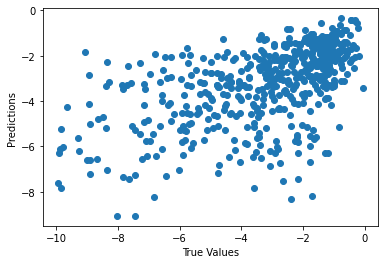

In [96]:
plt.scatter(y_test, reg.predict(X_test))
plt.xlabel("True Values")
plt.ylabel("Predictions")

# RandomForest

## подбор гипер параметров

Fitting 6 folds for each of 144 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  2.1min finished


{'bootstrap': True, 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
4.03584433332205


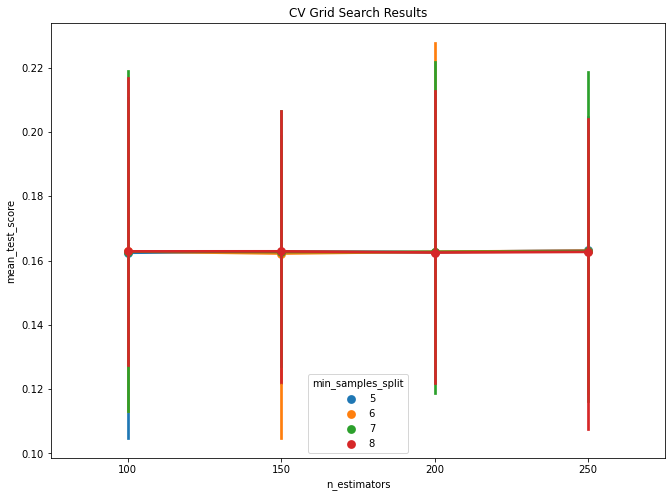

In [97]:
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import pandas as pd

def plot_cv_results(cv_results, param_x, param_z, metric='mean_test_score'):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, ci=99, n_boot=64, ax=ax)
    ax.set_title("CV Grid Search Results")
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.legend(title=param_z)
    return fig

param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 3, 4], 
    'min_samples_leaf': [2,3,4],
    'min_samples_split': [5, 6, 7, 8],
    'n_estimators': [100,150,200,250]
}
# Create a based model

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 6, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

#fig, axs = plt.subplots(figsize=(16, 5), ncols=4)


print(mean_squared_error(y_test, grid_search.predict(X_test)))
fig = plot_cv_results(grid_search.cv_results_, 'n_estimators', 'min_samples_split')

Text(0, 0.5, 'Predictions')

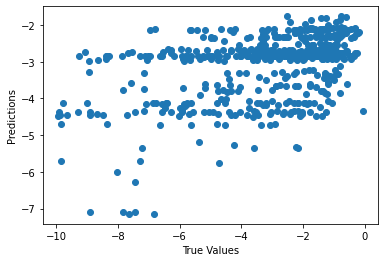

In [98]:
plt.scatter(y_test, grid_search.predict(X_test))
plt.xlabel("True Values")
plt.ylabel("Predictions")

## MSE, Графики на кросс-вале

Fitting 6 folds for each of 144 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  2.1min finished


MSE : 1
4.244195901756347
Fitting 6 folds for each of 144 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  2.1min finished


MSE : 2
4.06205064142449
Fitting 6 folds for each of 144 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  2.1min finished


MSE : 3
3.8204110514726417
Fitting 6 folds for each of 144 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  2.2min finished


MSE : 4
3.8124447109473296
Fitting 6 folds for each of 144 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  2.3min finished


MSE : 5
3.8381682797516414
Fitting 6 folds for each of 144 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  2.2min finished


MSE : 6
3.7443469007641306


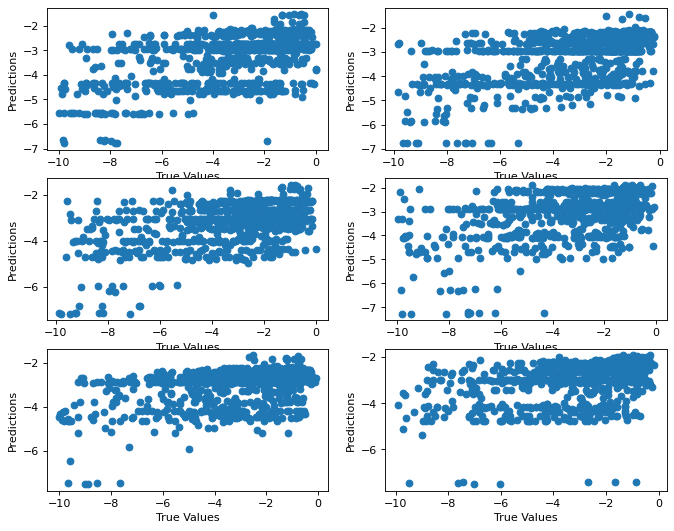

In [100]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=6)
kf.get_n_splits(X)


plt.figure(figsize=(10,8), dpi= 80)

i = 0
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_cross, X_test = X[train_index], X[test_index]
    y_cross, y_test = y[train_index], y[test_index]
    grid_search.fit(X_cross, y_cross)
    print("MSE :", i+1)
    print(mean_squared_error(y_test, grid_search.predict(X_test)))
    plt.subplot(321 + i)
    plt.scatter(y_test, grid_search.predict(X_test))
    i += 1
    plt.xlabel("True Values")
    plt.ylabel("Predictions")

plt.show()


# Catboost

## Подбор гиперпараметров

Fitting 6 folds for each of 18 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.7min finished


{'bagging_temperature': 0, 'bootstrap_type': 'Bayesian', 'learning_rate': 0.03}
2.3164803862742573


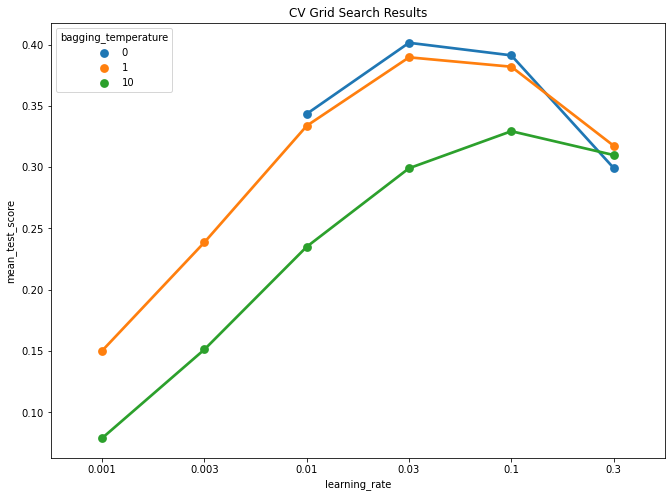

In [101]:
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
# Create a based model
cb = CatBoostRegressor(verbose=False)
# Instantiate the grid search model
param_grid = {
    'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
    'bootstrap_type':['Bayesian'],
    'bagging_temperature': [0, 1, 10]
}
grid_search = GridSearchCV(estimator = cb, param_grid = param_grid, 
                          cv = 6, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

#fig, axs = plt.subplots(figsize=(16, 5), ncols=4)

print(mean_squared_error(y_test, grid_search.predict(X_test)))


fig = plot_cv_results(grid_search.cv_results_, 'learning_rate', 'bagging_temperature')

## Сделаем честный кросс-вал

Fitting 6 folds for each of 18 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.7min finished


MSE : 1
3.4488813068953634
Fitting 6 folds for each of 18 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.7min finished


MSE : 2
3.125933276666884
Fitting 6 folds for each of 18 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.7min finished


MSE : 3
2.9161864010359086
Fitting 6 folds for each of 18 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.6min finished


MSE : 4
3.0094243428276655
Fitting 6 folds for each of 18 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.6min finished


MSE : 5
3.0395635651240855
Fitting 6 folds for each of 18 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.6min finished


MSE : 6
3.0503412940089354


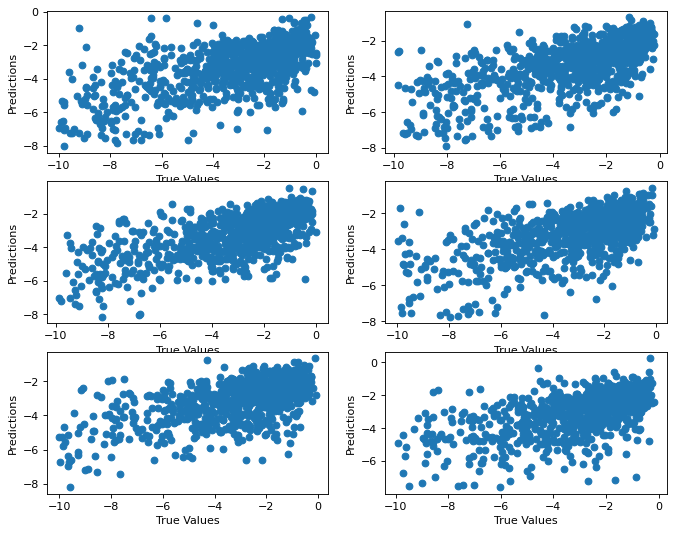

In [102]:
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, KFold


# Instantiate the grid search model

kf = KFold(n_splits=6)
kf.get_n_splits(X)


plt.figure(figsize=(10,8), dpi= 80)

i = 0
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_cross, X_test = X[train_index], X[test_index]
    y_cross, y_test = y[train_index], y[test_index]
    grid_search.fit(X_cross, y_cross)
    print("MSE :", i+1)
    print(mean_squared_error(y_test, grid_search.predict(X_test)))
    plt.subplot(321 + i)
    plt.scatter(y_test, grid_search.predict(X_test))
    i += 1
    plt.xlabel("True Values")
    plt.ylabel("Predictions")

plt.show()


# XGBoost

## Подбор гиперпараметров

Fitting 6 folds for each of 54 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:   23.3s finished


{'gamma': 0.3, 'max_depth': 3, 'min_child_weight': 3}
2.5730851885836157


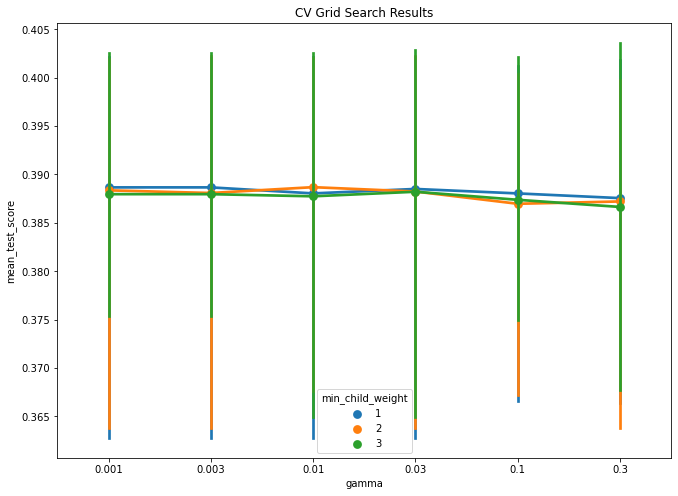

In [103]:
from xgboost import XGBRegressor


xgb = XGBRegressor(nthread=-1)

param_grid = {
    'max_depth': [2, 3, 4],
    'min_child_weight':[1,2,3],
    'gamma':[0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
}


grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                          cv = 6, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

#fig, axs = plt.subplots(figsize=(16, 5), ncols=4)

print(mean_squared_error(y_test, grid_search.predict(X_test)))


fig = plot_cv_results(grid_search.cv_results_, 'gamma', 'min_child_weight')


## MSE, Графики cross-val

Fitting 6 folds for each of 54 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:   22.0s finished


MSE : 1
3.5623615827766177
Fitting 6 folds for each of 54 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:   22.7s finished


MSE : 2
3.1243400598730457
Fitting 6 folds for each of 54 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:   22.1s finished


MSE : 3
2.932415432335353
Fitting 6 folds for each of 54 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:   21.7s finished


MSE : 4
2.9900777169329418
Fitting 6 folds for each of 54 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:   23.6s finished


MSE : 5
3.0220215202239404
Fitting 6 folds for each of 54 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:   24.2s finished


MSE : 6
3.032260118325507


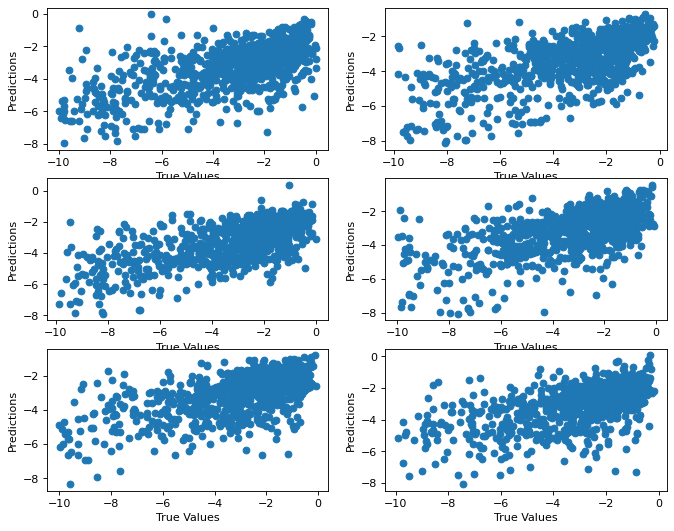

In [104]:

kf = KFold(n_splits=6)
kf.get_n_splits(X)


plt.figure(figsize=(10,8), dpi= 80)

i = 0
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_cross, X_test = X[train_index], X[test_index]
    y_cross, y_test = y[train_index], y[test_index]
    grid_search.fit(X_cross, y_cross)
    print("MSE :", i+1)
    print(mean_squared_error(y_test, grid_search.predict(X_test)))
    plt.subplot(321 + i)
    plt.scatter(y_test, grid_search.predict(X_test))
    i += 1
    plt.xlabel("True Values")
    plt.ylabel("Predictions")

plt.show()